## XGBoost.dt - English only


In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn

In [3]:
tweets = pd.read_pickle("../../Data/english_sentiment_with_confidence.pkl")
tweets

,text,conf
0,Grilling kabobs on the grill last night was am...,0.8439
1,The slowest day ever !! And the weather makes ...,0.6963
2,Fire Weather Watch issued May 17 at 4:21PM CDT...,0.8802
3,Im going to lunch early today. The weather i...,0.6897
4,Weekend Weather Causes Delays In I-270 Bridge ...,0.6153
...,...,...
29201,By this point some of my readers will be up in...,0.4450
29202,Members of that nobility had been prominent in...,0.7879
29203,He did his best to paper over the cracks.,0.4409
29204,Heavy dependence on sponsorship and arts counc...,0.3713


In [4]:
tweets.columns = ['text_clean', 'iaa']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7b8a56490>]],
      dtype=object)

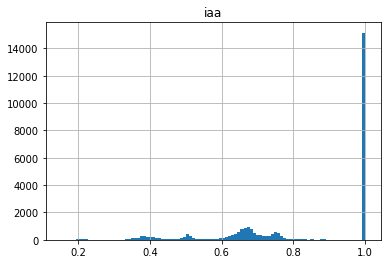

In [5]:
tweets.hist("iaa",bins= 100)

Check proportion of hard/easy tweets!

In [6]:
threshold = 0.90 # <--------------  ADJUST DIFFICULT TWEET THRESHOLD HERE
lables = tweets['iaa'] < threshold
tweets['difficult'] = tweets['iaa'] < threshold
print("There are " + str(tweets['difficult'].sum()) + " hard tweets in the current dataset." 
          " Which is " +  str(round(tweets['difficult'].sum()/len(tweets), ndigits = 3)*100) + "% of all tweets in the dataset")

There are 13963 hard tweets in the current dataset. Which is 47.8% of all tweets in the dataset


In [7]:
!pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import tensorflow_text

     |████████████████████████████████| 4.9 MB 8.2 MB/s 
     |████████████████████████████████| 462 kB 71.9 MB/s 


# Embedding 
I use the same as in the kNNdifficult tweet one
[linktekst](https://)


In [8]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
embedding = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return embedding(input)

module https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3 loaded


In [9]:
import pickle
with open("../../Data/embedded_random_english.pkl", 'rb') as f: 
    imported_tweets = pickle.load(f)

In [10]:
embedded_tweets = np.concatenate(imported_tweets)
embedded_tweets

array([[-0.06025866,  0.08329417,  0.04108945, ..., -0.04290623,
         0.00354118,  0.0078153 ],
       [-0.03279083, -0.07770784,  0.05461074, ..., -0.04724102,
        -0.00462033,  0.0944167 ],
       [ 0.04009258, -0.00561664, -0.02734125, ...,  0.0039615 ,
        -0.08937612,  0.0796641 ],
       ...,
       [-0.02512698,  0.02087881,  0.04560771, ...,  0.01631952,
         0.06022735,  0.06712218],
       [-0.0058883 ,  0.02951566, -0.0031851 , ...,  0.00214101,
         0.05493147,  0.08230514],
       [ 0.05226329,  0.08578635,  0.0457024 , ..., -0.08675157,
        -0.01197918,  0.03950243]], dtype=float32)

80/20 split

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embedded_tweets, 
                                                    lables.to_numpy(), test_size=0.2, 
                                                    random_state=42, stratify = lables.to_numpy())

Test stratify() command

In [12]:
sum(y_test)/len(y_test)

0.4780896953098254

## XGBoost Model Creation

note: classification tree

In [13]:
total = len(tweets)
pos = tweets['difficult'].sum()
neg = total - pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [14]:
Tweets_XGB = xgb.XGBClassifier(objective= "binary:logistic", seed = 42 , scale_pos_weight = weight_for_1) 

GridSearchCV to tune parameters (code taken from: https://www.kaggle.com/phunter/xgboost-with-gridsearchcv/script)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold #not used
from sklearn.metrics import plot_confusion_matrix

In [16]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [9,10,11,12],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [900,1000,1100], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

In [17]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer
make_scorer(fbeta_score, beta=2)

make_scorer(fbeta_score, beta=2)

In [18]:
Tweets_XGB_tuned = GridSearchCV(Tweets_XGB , 
                                parameters, 
                                n_jobs=5,  
                                scoring= ftwo_scorer, #also tried: recall, auc,...
                                verbose=1,
                                refit=True
                                ) 

fit tree to training data

In [19]:
Tweets_XGB_tuned.fit(X_train, # Adjust object if fitting works
                     y_train,
                     verbose = True,
                     early_stopping_rounds = 10,
                     eval_metric = "aucpr",
                     eval_set = [(X_test, y_test)]
                     )

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[0]	validation_0-aucpr:0.698953
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.723613
[2]	validation_0-aucpr:0.738906
[3]	validation_0-aucpr:0.743365
[4]	validation_0-aucpr:0.744929
[5]	validation_0-aucpr:0.749864
[6]	validation_0-aucpr:0.753966
[7]	validation_0-aucpr:0.75509
[8]	validation_0-aucpr:0.755529
[9]	validation_0-aucpr:0.756473
[10]	validation_0-aucpr:0.757757
[11]	validation_0-aucpr:0.759105
[12]	validation_0-aucpr:0.759337
[13]	validation_0-aucpr:0.761246
[14]	validation_0-aucpr:0.762538
[15]	validation_0-aucpr:0.763461
[16]	validation_0-aucpr:0.764083
[17]	validation_0-aucpr:0.764294
[18]	validation_0-aucpr:0.764284
[19]	validation_0-aucpr:0.764742
[20]	validation_0-aucpr:0.765043
[21]	validation_0-aucpr:0.766122
[22]	validation_0-aucpr:0.76689
[23]	validation_0-aucpr:0.767858
[24]	validation_0-aucpr:0.767869
[25]	validation_0-aucpr:0.768214
[26]	validation_0-aucpr:0.7

GridSearchCV(estimator=XGBClassifier(scale_pos_weight=1.045835422187209,
                                     seed=42),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [9, 10, 11, 12], 'min_child_weight': [11],
                         'missing': [-999], 'n_estimators': [900, 1000, 1100],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'seed': [1337], 'silent': [1], 'subsample': [0.8]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


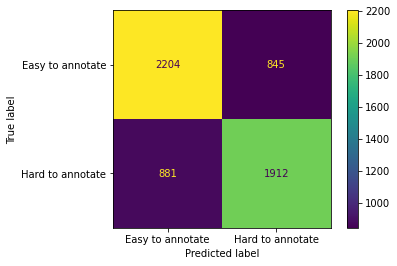

In [20]:
plot_confusion_matrix(Tweets_XGB_tuned, 
                      X_test, 
                      y_test,
                      values_format= "d",
                      display_labels= ["Easy to annotate", "Hard to annotate"],
                      colorbar=True
                      )

In [21]:
y_pred = Tweets_XGB_tuned.predict(X_test)
y_pred_raw = Tweets_XGB_tuned.predict_proba(X_test)

In [22]:
from sklearn.metrics import fbeta_score
print("The F_beta score is " + str(round(fbeta_score(y_test, y_pred, average='weighted', beta=2), ndigits = 3)*100)+ "% (with a beta of 2).") 

The F_beta score is 70.5% (with a beta of 2).


##precision-recall curve

Logistic: f1=0.689 auc=0.783


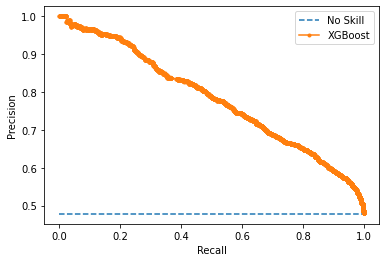

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc 
import matplotlib.pyplot as pyplot
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_raw[:,1])
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='XGBoost')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

#Export data

In [24]:
df = pd.DataFrame({"Truth":y_test, "Pred":y_pred, "Prob": y_pred_raw[:,1] })

In [25]:
df.to_csv("/content/drive/MyDrive/Thesis/MLAlgorithms/XGBoost/resultsXGBoostEnglish.csv")